In [1]:
from IPython.core.interactiveshell import InteractiveShell  #执行该代码可以使得当前nb支持多输出
InteractiveShell.ast_node_interactivity = "all" 
import numpy as np
from datetime import datetime
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
pd.options.display.max_rows = 8  
%matplotlib inline

import os, sys
import statsmodels, arch

print(sys.version)
print('statsmodels version: ',statsmodels.__version__, 
    '; arch version: ', arch.__version__)

3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
statsmodels version:  0.12.0 ; arch version:  4.19


金融时间序列的特征包括相关性与关联性、趋势性与趋势变动性、自相关性、数据生成机制的动态变化性、波动聚集性、分形以及多重分形等


## 相关性

所谓相关性是指某种金融资产价格(或者其收益率)的变化引起其他资产发生相关的变化。在金融领域，许多情况下需要知道两个资产间是如何相互作用的，例如在投资组合管理中，为了度量一个投资组合的风险程度，就需要知道该组合中一个证券的价格是如何影响其他证券价格的。研究资产间相关性的主要方法是使用协方差。


### 平稳性

为了能够依据过去的数据对未来做出预测，我们需要数据是平稳的。

弱平稳序列 (宽平稳序列，weakly stationary time series): 如果时间序列 $\left\{X_{t}\right\}$ 存在有限的二阶矩且满足:
1. $E X_{t}=\mu$ 与 $t$ 无关
2. $\operatorname{Var}\left(X_{t}\right)=\gamma_{0}$ 与 $t$ 无关
3. $\gamma_{k}=\operatorname{Cov}\left(X_{t-k}, X_{t}\right), k=1,2, \ldots$ 与 $t$ 无关。

则称 $\left\{X_{t}\right\}$ 为**弱平稳序列**。

弱平稳是相对严平稳而言的，对时间序列 $\left\{X_{t}, t \in \mathbb{Z}\right\},$ 如果对任意的 $t \in \mathbb{Z}$ 和正整数 $n, k,\left(X_{t}, \ldots, X_{t+n-1}\right)$ 总是与 $\left(X_{t+k}, \ldots, X_{t+n-1+k}\right)$ 同分布，则称 $\left\{X_{t}\right\}$ 为严平稳时间序列。

如果严平稳时间序列 $\left\{X_{t}\right\}$ 有二阶矩，则它也是宽平稳的。
如果宽平稳时间序列 $\left\{X_{t}\right\}$ 的任意有限维分布都服从正态分布，则 $\left\{X_{t}\right\}$ 也是严平稳的。


In [2]:
national_debt = pd.read_csv('data/中国五年期国债收益率历史数据.csv',index_col = 0)  # 读取股票文件
national_debt.head()
national_debt.describe()

national_debt.sort_values(by='日期',ascending=True,inplace=True)
national_debt.head()
#national_debt.to_csv("data/national_debt_5y.csv",encoding='gbk',index = True)

,收盘,开盘,高,低,涨跌幅
日期,,,,,
2022-02-21,2.506,2.500,2.520,2.497,0.00%
2022-02-18,2.505,2.511,2.511,2.479,0.93%
2022-02-17,2.482,2.526,2.526,2.478,-0.72%
2022-02-16,2.500,2.559,2.559,2.498,-0.48%
2022-02-15,2.512,2.580,2.580,2.501,-0.32%


,收盘,开盘,高,低
count,1563.000000,1563.000000,1563.000000,1563.000000
mean,3.022280,3.041862,3.049060,3.010074
std,0.420101,0.419688,0.418939,0.420670
min,1.740000,1.740000,1.740000,1.740000
25%,2.712000,2.746000,2.750000,2.697000
50%,2.993000,3.012000,3.018000,2.983000
75%,3.234000,3.261000,3.269000,3.219000
max,3.968000,4.000000,4.000000,3.952000


,收盘,开盘,高,低,涨跌幅
日期,,,,,
2016-01-21,2.700,2.683,2.703,2.680,0.78%
2016-01-22,2.689,2.705,2.705,2.682,-0.41%
2016-01-25,2.694,2.750,2.750,2.680,0.19%
2016-01-26,2.738,2.703,2.740,2.690,1.63%
2016-01-27,2.774,2.763,2.783,2.763,1.31%



## 单位根检验

时间序列的平稳性对TSA至关重要，那么我们应该如何判断一个时间序列是不是平稳的呢？

1. 观察时间序列图的形状来初步判断其平稳性。根据弱平稳的定义，时间序列的均值和方差为常数，**因此其时序图应该围绕某一水平线上下以大致相同的幅度波动。如果该时序图存在明显递增、递减或周期性波动，则该时间序列很可能是不平稳的。**
2. 观察序列的自相关和偏自相关函数图。对于平稳时间序列而言，**其自相关或偏自相关系数一般会快速减小至0附近或者在某一阶后变为0**，而非平稳的时间序列的自相关系数一般是缓慢下降而不是快速减小。
3. 单位根检验。

随机游走$p_{t}=p_{t-1}+\varepsilon_{t}$是单位根过程一个很好的例子。一般地，设$p_{0}=0$ 单位根过程 $\left\{p_{t}\right\}$ 有如下特点:
+ $p_{t}$ 期望值等于 0 ;
+ $p_{t}$ 方差等于 $\sigma^{2} t,$ 随 $t$ 线性增长，趋于无穷:
+ 历史的扰动（新息）的影响不衰减:
+ 预测只能用最后一个观测值作为预测，预测均方误差趋于无穷。
+ 样本 ACF 表现为基本不衰减，近似等于 1 。

单位根非平稳列是金融中最常用的非平稳模型，单位根非平稳列不能使用平稳列的模型来建模。所以，要建模的序列应该进行 “单位根检验”。

Python执行单位根检验可以使用`arch`模块中的`arch.unitroot.ADF`函数，它可以较好地输出检验结果；此外，还有`statsmodels`的`statsmodels.stats.diagnostic unitroot_adf`函数和`statsmodels.tsa.stattools.adfuller`函数。

In [4]:
from arch.unitroot import ADF

print(ADF(national_debt.开盘))

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.162
P-value                         0.220
Lags                               21
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


可以看到，p-value大于0.1，拒绝了序列 x 的平稳性。

### 自协方差函数

自协方差函数：时间序列 $\left\{X_{t}\right\}$ 中两个随机变量的协方差 $\operatorname{Cov}\left(X_{s}, X_{t}\right)$ 叫做自协方差。如果 $\operatorname{Cov}\left(X_{s}, X_{t}\right)=\gamma_{|t-s|}$ 仅 依赖于 $t-s,$ 则称
$$
\gamma_{k}=\operatorname{Cov}\left(X_{t-k}, X_{t}\right), k=0,1,2, \ldots
$$
为时间序列 $\left\{X_{t}\right\}$ 的自协方差函数。易见 $\gamma_{0}=\operatorname{Var}\left(X_{t}\right)$ 。
由 Cauchy-Schwartz 不等式,
$$
\left|\gamma_{k}\right|=\left|E\left[\left(X_{t-k}-\mu\right)\left(X_{t}-\mu\right)\right]\right| \leq\left(E\left(X_{t-k}-\mu\right)^{2} E\left(X_{t}-\mu\right)^{2}\right)^{1 / 2}=\gamma_{0}
$$
适当条件下可以**用时间序列的样本估计自协方差函数**，这是用一条轨道的信息推断所有实验结果 $\Omega,$ 估计公式为
$$
\hat{\gamma}_{k}=\frac{1}{T} \sum_{t=k+1}^{T}\left(x_{t-k}-\bar{x}\right)\left(x_{t}-\bar{x}\right), k=0,1, \ldots, T-1
$$
称 $\hat{\gamma}_{k}$ 为样本自协方差。注意这里用了 $1 / T$ 而不是 $1 /(T-k),$ 用 $1 /(T-k)$ 在获得无偏性的同时会造成一些理论上
的困难。
令：
$$
\rho\left(X_{t-k}, X_{t}\right)=\frac{\operatorname{Cov}\left(X_{t-k}, X_{t}\right)}{\sqrt{\operatorname{Var}\left(X_{t-k}\right) \operatorname{Var}\left(X_{t}\right)}}=\frac{\gamma_{k}}{\sqrt{\gamma_{0} \gamma_{0}}}=\frac{\gamma_{k}}{\gamma_{0}}, k=0,1, \ldots, \forall t
$$
记 $\rho_{k}=\gamma_{k} / \gamma_{0},$ 这是 $X_{t-k}$ 与 $X_{t}$ 的相关系数且与 $t$ 无关，称 $\left\{\rho_{k}, k=0,1, \ldots\right\}$ 为时间序列 $\left\{X_{t}\right\}$ 的自相关函数（Autocorrelation function, ACF）
适当条件下 $\rho_{k}$ 可以从时间序列样本估计为
$$
\hat{\rho}_{k}=\frac{\hat{\gamma}_{k}}{\hat{\gamma}_{0}}, k=0,1, \ldots
$$
$\hat{\rho}_{0}=1$ 。称 $\hat{\rho}_{k}, k=1,2, \ldots$ 为样本自相关函数。

`statsmodels.tsa.api.graphics.plot_acf`函数可以估计时间序列 x 的自相关函数并对其前面若干项画图

### 偏自相关性

为了剔除其他各期的影响，单纯考察过去某一单期对今天的影响，引入偏自相关函数（Partial Autocorrelation Coefficient，简称PACF），即条件自相关系数，使用数学公式表示为：

$$
P A C F_{k}=\operatorname{Corr}\left(X_{t}, X_{t-k} \mid X_{t-1}, X_{t-2}, \ldots, X_{t-k+1}\right)
$$

偏自相关函数可以通过自回归模型来表述和求解。

`statsmodels.tsa.api.graphics.plot_pacf`函数可以估计时间序列的偏自相关函数并对其前面若干项画图。

以下这个函数`tsplot`能够画出时间序列和其acf、pacf图。

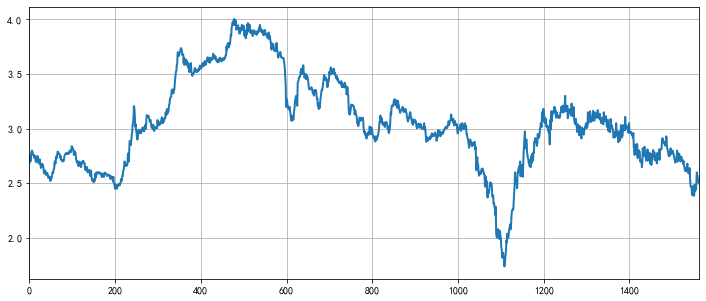

In [15]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 

national_debt.开盘.plot(use_index=False,figsize=(12,5),linewidth=2,grid=True)
plt.show()

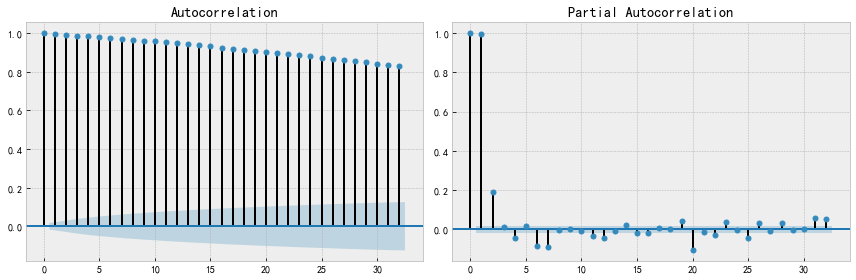

In [13]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 

from scipy import stats
from arch.unitroot import ADF

def tsplot(y, lags=None, figsize=(12, 4), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (1, 2)
      
        acf_ax = plt.subplot2grid(layout, (0, 0))
        pacf_ax = plt.subplot2grid(layout, (0, 1))
         
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        
        plt.tight_layout()

tsplot(national_debt.开盘)

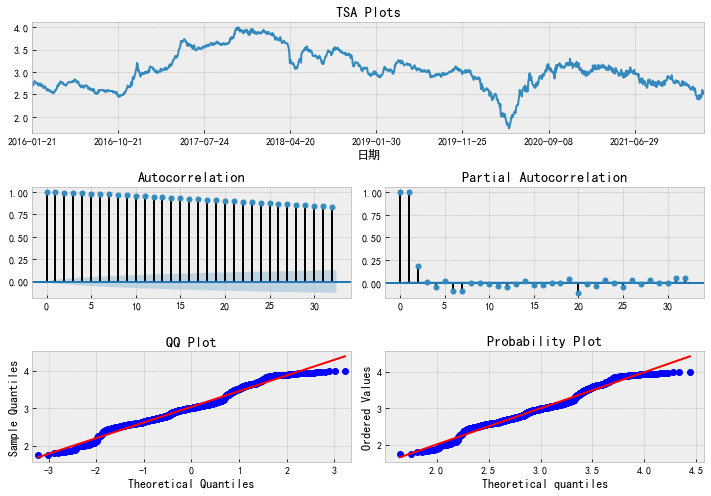

In [21]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 

from scipy import stats
from arch.unitroot import ADF

def tsplot(y, lags=None, figsize=(10, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('TSA Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        stats.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        
        plt.tight_layout()

tsplot(national_debt.开盘)

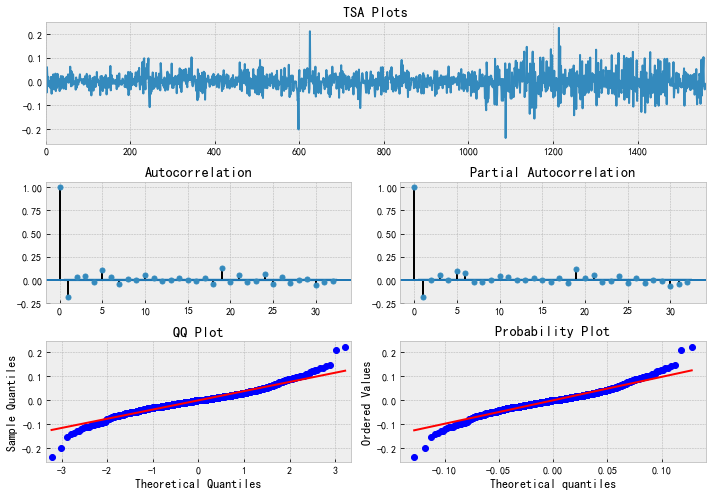

In [22]:
#可以看到序列自相关性是很高的，从序列表现来看也不够平稳性，所以需要做一阶差分
tsplot(np.diff(national_debt.开盘))

### 线性模型

$$
y_{t}=b_{0}+b_{1} t+\epsilon_{t}
$$

其中 $\left\{\varepsilon_{t}\right\}$ 是零均值独立同分布白噪声列。

## 自回归模型（AR）

如果 $\rho_{1} \neq 0,$（自相关函数） 则 $X_{t}$ 与 $X_{t-1}$ 相关，可以用 $X_{t-1}$ 预测 $X_{t^{\circ}}$。最简单的预测为线性组合，如下模型:
$$
X_{t}=\phi_{0}+\phi_{1} X_{t-1}+\varepsilon_{t}
$$
称为一阶自回归模型 (Autoregression model)，记作 $\mathrm{AR}(1)$ 模型。其中 $\left\{\varepsilon_{t}\right\}$ 是**零均值独立同分布白噪声**序列，方差为 $\sigma^{2}$，并设 $\varepsilon_{t}$ 与 $X_{t-1}, X_{t-2}, \ldots$ 独立。系数 $\left|\phi_{1}\right|<1$ 。更一般的定义中仅要求 $\left\{\varepsilon_{t}\right\}$ 是零均值白噪声，不要求独立同分布。

AR(1) 模型是马尔可夫 (Markov) 过程: $X_{t}$ 在 $X_{t-1}, X_{t-2}, \ldots$ 条件下的条件分布，只与 $X_{t-1}$ 有关。已知 $X_{t-1}$后，用 $X_{t-1}, X_{t-2}, \ldots$ 去预测 $X_{t},$ 与仅用 $X_{t-1}$ 去预测的效果相同。

条件期望和条件方差:
$$
E\left(X_{t} \mid X_{t-1}\right)=\phi_{0}+\phi_{1} X_{t-1}, \quad \operatorname{Var}\left(X_{t} \mid X_{t-1}\right)=\sigma^{2}
$$
即在 $X_{t-1}=x_{t-1}$ 已知后， $X_{t}$ 条件的条件分布是期望为 $\phi_{0}+\phi_{1} x_{t-1},$ 方差为 $\sigma^{2}$ 的分布。可以证明
$$
\operatorname{Var}\left(X_{t}\right)=\frac{\sigma^{2}}{1-\phi_{1}^{2}}
$$
因为 $\left|\phi_{1}\right|<1,$ 所以 $X_{t}$ 在 $X_{t-1}=x_{t-1}$ 已知条件下的条件方差小于其无条件方差，也就是说**用 $X_{t-1}$ 的信息去预测 $X_{t},$ 可以使得 $X_{t}$ 的波动减小，能够达到预测的效果。**

$\mathrm{AR}(1)$ 模型的推广是 $\mathrm{AR}(p)$ 模型:
$$
X_{t}=\phi_{0}+\phi_{1} X_{t-1}+\cdots+\phi_{p} X_{t-p}+\varepsilon_{t}
$$

$\mathrm{AR}(p)$平稳的充要条件是特征多项式：
$$
1-\phi_{1} z-\cdots-\phi_{p} z^{p}=0
$$
的所有复根都在单位圆外。

对 $\operatorname{AR}(1)$ 就是要求 $\left|\phi_{1}\right|<1$


In [18]:
import statsmodels, arch
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa import ar_model
# from statsmodels.tsa.arima.model import ARIMA

# AIC 准则，最大阶数 10
est = ar_model.ar_select_order(national_debt.开盘, maxlag=10, ic='aic', trend='n', glob=True)
est.aic
est.model
print(est.ar_lags)

D:\Anaconda3\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Anaconda3\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


{(1, 2, 5, 7): -6.562215030423224,
 (1, 2, 5, 6, 7): -6.561856744417278,
 (1, 2, 5, 7, 9): -6.561613567754643,
 (1, 2, 5, 6, 7, 9): -6.561502556447415,
 (1, 2, 3, 5, 7): -6.561500786910078,
 (1, 2, 5, 7, 10): -6.561432427123681,
 (1, 2, 5, 7, 8): -6.561407521753694,
 (1, 2, 5, 6, 7, 8): -6.561309677886626,
 (1, 2, 3, 5, 6, 7): -6.561282599838532,
 (1, 2, 4, 5, 7): -6.561234705367534,
 (1, 2, 5, 6, 7, 10): -6.561204987050104,
 (1, 2, 3, 4, 5, 7): -6.5610523457263135,
 (1, 2, 3, 5, 6, 7, 9): -6.560864655987414,
 (1, 2, 3, 5, 7, 9): -6.560837501382668,
 (1, 2, 4, 5, 6, 7): -6.5607640786208785,
 (1, 2, 3, 5, 7, 10): -6.560738852810981,
 (1, 2, 4, 5, 7, 9): -6.560703786066952,
 (1, 2, 3, 4, 5, 6, 7): -6.560671019281253,
 (1, 2, 3, 5, 6, 7, 10): -6.560667701697374,
 (1, 2, 3, 5, 6, 7, 8): -6.560637377195973,
 (1, 2, 3, 5, 7, 8): -6.560610790697748,
 (1, 2, 3, 4, 5, 7, 9): -6.560473937996771,
 (1, 2, 4, 5, 6, 7, 9): -6.560461148353991,
 (1, 2, 4, 5, 7, 10): -6.560454631816256,
 (1, 2, 4, 5, 7

[1 2 5 7]


拟合的最优阶数是[1 2 5 7]，我们来看一看其他的拟合信息： smt.AutoReg让我们能以任意阶数拟合一个 AR 模型并输出结果。

In [6]:
model = smt.AutoReg(national_debt.开盘, lags=1, trend='n').fit()
print(model.summary())

                            AutoReg Model Results                             
Dep. Variable:                     开盘   No. Observations:                 1563
Model:                     AutoReg(1)   Log Likelihood                2873.756
Method:               Conditional MLE   S.D. of innovations              0.038
Date:                Sat, 05 Mar 2022   AIC                             -6.515
Time:                        16:37:40   BIC                             -6.508
Sample:                             1   HQIC                            -6.512
                                 1563                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
开盘.L1          0.9999      0.000   3157.330      0.000       0.999       1.001
                                    Roots                                    
                  Real          Imaginary           M

D:\Anaconda3\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Anaconda3\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


系数的估计是 0.9999

### 信息准则

要寻找适合AR模型的最优阶数，其基本思想是**模型拟合数据的拟合优度与模型简单化的折衷。** 我们通常称为“信息准则”。

AIC 准则（Akaike's Information Criterion）
$$
\mathrm{AIC}=-\frac{2}{T} \ln (\text { 似然函数值 })+\frac{2}{T}(\text { 参数个数 })
$$
其中似然函数值是在参数最大似然估计处的似然函数值。当模型为高斯 $\mathrm{AR}({p}),$ 即 $\left\{\epsilon_{t}\right\}$ 是独立同 $\mathrm{N}\left(0, \sigma^{2}\right)$ 序列时的 $\operatorname{AR}(p)$ 模型时，AIC 公式为
$$
\operatorname{AIC}(k)=\ln \tilde{\sigma}_{k}^{2}+\frac{2 k}{T}
$$
其中 $k$ 是模型的阶, $\tilde{\sigma}_{k}^{2}$ 是阶为 $k$ 的条件下 $\varepsilon_{t}$ 的方差的最大似然估计。 $\ln \tilde{\sigma}_{k}^{2}$ 代表了模型对数据的拟合优劣，此值越 大拟合越差 $; \frac{2 k}{T}$ 是对模型复杂程度的惩罚，此值越大,模型越复杂，稳定性越差，对未来的情况的适应性也越差。**在某个范围内取 $k$ 使得 AIC $(k)$ 最小，就达成了拟合优度与模型简单程度的折衷。**

另一个常用的信息准则是 $\mathrm{BIC}$ 准则 $($ Bayesian Information Criterion $)$
$$
\mathrm{BIC}(k)=\ln \tilde{\sigma}_{k}^{2}+\frac{k \ln T}{T}
$$

BIC 倾向于取比 AIC 更低阶的模型。

经验上，拟合的最大阶数不超过$10 \log_{10} T$，$T$是时间序列的长度。

`smt.arma_order_select_ic`函数也可以输出拟合的AIC准则的具体值。

In [7]:
len(national_debt.开盘)

1563

D:\Anaconda3\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Anaconda3\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,
D:\Anaconda3\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Anaconda3\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


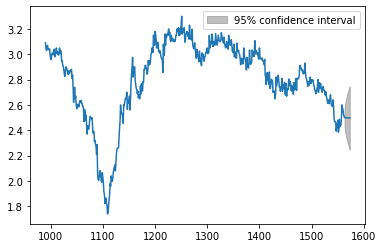

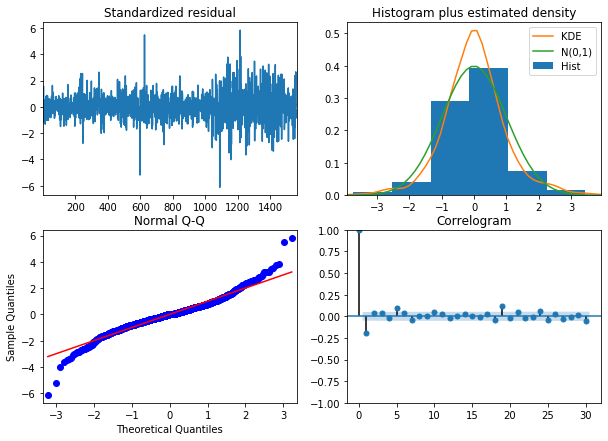

In [8]:
ax = model.plot_predict(990, 1573)

ax = model.plot_diagnostics(lags=30, figsize=(10,7))

对于拟合好的AR模型，可以用`predict`进行预测，通常对于高阶模型能够有更长时间的预测。

## 移动平均模型（MA）

MA(q)模型与AR(p)模型非常相似。不同的是，MA(q)模型是过去白噪声误差项的线性组合，而不像AR(p)模型那样是过去观测值的线性组合。MA模型的动机是通过对误差项进行拟合，可以直接观察到误差过程中的“冲击”。在AR(p)模型中，这些冲击是通过使用ACF对过去的一系列观测数据进行间接观测得到的。

MA(q)模型的公式为：

$$
X_{t}=\theta_{0}+\varepsilon_{t}+\theta_{1} \varepsilon_{t-1}+\cdots+\theta_{q} \varepsilon_{t-q}
$$

此模型也有特征多项式
$$
1+\theta_{1} z+\cdots+\theta_{q} z^{q}
$$
特征方程的根称为特征根，特征根都在单位圆外的条件称为 MA 模型的可逆条件。平稳性并不需要特征根的条件。

以下模拟一个MA(1)模型。

In [9]:
from statsmodels.tsa.arima.model import ARIMA

smt.arma_order_select_ic(national_debt.开盘, ic='aic', trend='nc')

D:\Anaconda3\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


{'aic':              0            1            2
 0          NaN  5811.049024  3865.548621
 1 -5738.699178 -5791.932172 -5793.971789
 2 -5794.706847 -5792.712021 -5789.240170
 3 -5792.714815 -5793.056171 -5795.681037
 4 -5794.879656 -5794.272914 -5801.157675, 'aic_min_order': (4, 2)}

In [10]:
# ARIMA(p, d, q)
ARIMA(national_debt.开盘, order=(0, 0, 1), trend='n').fit().summary()

D:\Anaconda3\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Anaconda3\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Anaconda3\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     开盘   No. Observations:                 1563
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -2903.525
Date:                Sat, 05 Mar 2022   AIC                           5811.049
Time:                        16:42:05   BIC                           5821.758
Sample:                             0   HQIC                          5815.030
                               - 1563                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9914      0.004    270.727      0.000       0.984       0.999
sigma2         2.3985      0.388      6.179      0.000       1.638       3.159
===================================================================================
Ljung-Box (L1) (Q):                 222.79   Jarque-Bera (JB):                97.28
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                             0.47
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

以 $\operatorname{MA}(1)$ 为例。 $X_{t}=\theta_{0}+\varepsilon_{t}+\theta_{1} \varepsilon_{t-1},$ 其中 $\left\{\varepsilon_{t}\right\}$ 是零均值独立同分布白噪声， $\theta_{0}, \theta_{1}$ 是任意实数，平稳性不需要
特征根的条件。
易见
$$
E X_{t}=\theta_{0}, \forall t, \quad \operatorname{Var}\left(X_{t}\right)=\sigma^{2}\left(1+\theta_{1}^{2}\right)
$$
而
$$
\gamma_{1}=E\left[\left(X_{t}-\theta_{0}\right)\left(X_{t-1}-\theta_{0}\right)\right]=E\left[\left(\varepsilon_{t}+\theta_{1} \varepsilon_{t-1}\right)\left(\varepsilon_{t-1}+\theta_{1} \varepsilon_{t-2}\right)\right]=\theta_{1} E \varepsilon_{t-1}^{2}=\sigma^{2} \theta_{1}
$$
对 $k>1$ 有
$$
\gamma_{k}=E\left[\left(\varepsilon_{t}+\theta_{1} \varepsilon_{t-1}\right)\left(\varepsilon_{t-k}+\theta_{1} \varepsilon_{t-k-1}\right)\right]=0(k>1)
$$
因为 $k>1,$ 所以 $t-k-1<t-k<t-1<t,$ 求协方差时均不相关。
所以，对于 MA(1) 序列，有
$$
\gamma_{k}=\left\{\begin{array}{ll}
\sigma^{2}\left(1+\theta_{1}^{2}\right), & k=0 \\
\sigma^{2} \theta_{1}, & k=1 \\
0, & k>1
\end{array}\right.
$$
相应地，MA(1) 的自相关函数为
$$
\rho_{k}=\left\{\begin{array}{ll}
1, & k=0 \\
\frac{\theta_{1}}{1+\theta_{1}^{2}}, & k=1 \\
0, & k>1
\end{array}\right.
$$
这就验证了 MA(1) 序列是弱平稳列。MA(1) 的自相关函数在 $k>1$ 后为零的性质叫做 MA 序列的自相关函数截尾性。

MA 序列的自相关函数截尾性也是在模型识别和定阶时的重要依据。

**小结**：
- 对 $\mathrm{MA}(q)$ 模型，ACF 对定阶有意义，因为其 $q$ 后截尾;
- 对 $\mathrm{AR}(p)$ 模型，PACF 对定阶有意义，因为其 $p$ 后截尾;

## ARMA 模型

正如你可能已经想到的，ARMA模型只是AR(p)和MA(q)模型的合并。让我们从定量金融的角度回顾一下这些模型代表了什么：
+ AR(p) 模型试图捕捉（解释）交易市场中经常观察到的动量和均值回归效应。
+ MA(q) 模型试图捕捉（解释）在白噪声项下观察到的冲击效应。这些冲击效应可以被认为是影响观察过程的意外事件，例如意外收入、恐怖袭击等，这类意外事件对市场的影响随着时间衰减。